In [1]:
import sys
import os
import numpy as np
import cv2
import openslide
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator
import xml.etree.ElementTree as ET
from xml.dom import minidom
import geojson
import argparse
import matplotlib.pyplot as plt
import fastai
from fastai.vision.all import *
import PIL
matplotlib.use('Agg')
import pandas as pd
import datetime
from skimage import draw, measure, morphology, filters
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon, shape
from shapely.ops import cascaded_union, unary_union
import json
import shapely
import warnings
from scipy import ndimage
import h5py
from Utils import *
warnings.filterwarnings("ignore")

/home/jliu6/anaconda3/envs/paimg1/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/jliu6/anaconda3/envs/paimg1/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import torchvision
import torch
from platform import python_version
print("Python: " + python_version())
print("fastai: " + fastai.__version__)
print("torch: " + torch.__version__)
print("torchvision: " + torchvision.__version__)

Python: 3.11.0
fastai: 2.7.12
torch: 2.0.1
torchvision: 0.15.2


In [3]:
def create_dir_if_not_exists(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Directory '{dir_path}' created.")
    else:
        print(f"Directory '{dir_path}' already exists.")


def generate_deepzoom_tiles(slide, save_image_size, pixel_overlap, limit_bounds):
    # this is physical microns per pixel
    acq_mag = 10.0/float(slide.properties[openslide.PROPERTY_NAME_MPP_X])

    # this is nearest multiple of 20 for base layer
    base_mag = int(20 * round(float(acq_mag) / 20))

    # this is how much we need to resample our physical patches for uniformity across studies
    physSize = round(save_image_size*acq_mag/base_mag)

    # grab tiles accounting for the physical size we need to pull for standardized tile size across studies
    tiles = DeepZoomGenerator(slide, tile_size=physSize-round(pixel_overlap*acq_mag/base_mag), overlap=round(pixel_overlap*acq_mag/base_mag/2), 
                              limit_bounds=limit_bounds)

    # calculate the effective magnification at each level of tiles, determined from base magnification
    tile_lvls = tuple(base_mag/(tiles._l_z_downsamples[i]*tiles._l0_l_downsamples[tiles._slide_from_dz_level[i]]) for i in range(0,tiles.level_count))

    return tiles, tile_lvls, physSize


def extract_tile_start_end_coords(all_tile, deepzoom_lvl, x_loc, y_loc):
    r'''
    #This func returns the coordiates in the reference level 0 pixels
    '''
    #Get coords
    tile_coords = all_tile.get_tile_coordinates(deepzoom_lvl, (x_loc, y_loc))

    #Get top left pixel coordinates
    topleft_x = tile_coords[0][0]
    topleft_y = tile_coords[0][1]

    #Get level (original)
    o_lvl = tile_coords[1]

    #Get downsample factor
    ds_factor = all_tile._l0_l_downsamples[o_lvl] #downsample factor

    #Get region size in current level 
    rsize_x = tile_coords[2][0] 
    rsize_y = tile_coords[2][1] 

    #Get tile starts and end   
    start_loc = tile_coords[0] #start
    end_loc = (int(topleft_x + ds_factor * rsize_x), int(topleft_y + ds_factor* rsize_y)) #end

    #Get save coord name (first two is the starting loc, and the last two are the x and y size considering dsfactor)
    coord_name = str(topleft_x) + "-" + str(topleft_y) + "_" + '%.0f' % (ds_factor * rsize_x) + "-" + '%.0f' % (ds_factor * rsize_y)
    
    return start_loc, end_loc, coord_name, tile_coords


In [4]:
cur_wd = '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/'
save_location = cur_wd + 'intermediate_data/cancer_prediction_results102824/'  
save_location2 = cur_wd + 'intermediate_data/cancer_prediction_results102824/tiles/'  
save_location3 = cur_wd + 'intermediate_data/cancer_prediction_results102824/cancer_pred_out/'  
mag_extract = 20 # do not change this, model trained at 250x250 at 20x
save_image_size = 250  # do not change this, model trained at 250x250 at 20x
pixel_overlap = 100  # specify the level of pixel overlap in your saved images
limit_bounds = True  # this is weird, dont change it
tiff_lvl =2 # low res pyramid level to grab
model_path_m = cur_wd + 'models/cancer_detection_models/mets/ft_models/dlv3_2ep_2e4_update-07182023_RT_fine_tuned..pkl'
model_path_l = cur_wd + 'models/cancer_detection_models/local/binary_mblntv3_25ep_lr1e5_wAug_MixUpLS_sz500_bs12_10x.pkl'
data_mut_path = cur_wd + 'data/MutationCalls/'
save_location4 = save_location3 + str(pixel_overlap) + 'and' + str(tiff_lvl)  # args.save_location

In [5]:
create_dir_if_not_exists(save_location)
create_dir_if_not_exists(save_location2)
create_dir_if_not_exists(save_location3)
create_dir_if_not_exists(save_location4)

Directory '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/intermediate_data/cancer_prediction_results102824/' already exists.
Directory '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/intermediate_data/cancer_prediction_results102824/tiles/' already exists.
Directory '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/intermediate_data/cancer_prediction_results102824/cancer_pred_out/' already exists.
Directory '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/intermediate_data/cancer_prediction_results102824/cancer_pred_out/100and2' already exists.


In [6]:
#load mutation site
mut_site_df = pd.read_excel(data_mut_path + 'OPX_anatomic sites.xlsx')
mut_site_df
mets_ids = list(mut_site_df.loc[mut_site_df['Anatomic site']!= 'Prostate', 'OPX_Number'])
local_ids = list(mut_site_df.loc[mut_site_df['Anatomic site']== 'Prostate', 'OPX_Number'])
len(mets_ids)
len(local_ids)

80

In [7]:
#All files list
#flist=sorted(glob.glob(cur_wd + '/data/OPX/*.tif'))

In [8]:
#Select IDs
selected_ids = mets_ids #mets_ids, local_ids
print(selected_ids)

['OPX_001', 'OPX_003', 'OPX_004', 'OPX_005', 'OPX_006', 'OPX_007', 'OPX_008', 'OPX_009', 'OPX_010', 'OPX_012', 'OPX_017', 'OPX_018', 'OPX_021', 'OPX_024', 'OPX_025', 'OPX_028', 'OPX_033', 'OPX_038', 'OPX_039', 'OPX_040', 'OPX_043', 'OPX_044', 'OPX_045', 'OPX_047', 'OPX_049', 'OPX_052', 'OPX_053', 'OPX_055', 'OPX_056', 'OPX_057', 'OPX_059', 'OPX_062', 'OPX_063', 'OPX_064', 'OPX_065', 'OPX_066', 'OPX_068', 'OPX_069', 'OPX_070', 'OPX_071', 'OPX_072', 'OPX_075', 'OPX_077', 'OPX_078', 'OPX_079', 'OPX_080', 'OPX_083', 'OPX_084', 'OPX_085', 'OPX_086', 'OPX_087', 'OPX_090', 'OPX_092', 'OPX_098', 'OPX_099', 'OPX_102', 'OPX_105', 'OPX_106', 'OPX_107', 'OPX_108', 'OPX_109', 'OPX_113', 'OPX_114', 'OPX_115', 'OPX_116', 'OPX_119', 'OPX_120', 'OPX_121', 'OPX_122', 'OPX_124', 'OPX_125', 'OPX_126', 'OPX_127', 'OPX_128', 'OPX_130', 'OPX_131', 'OPX_132_1', 'OPX_132_2', 'OPX_135', 'OPX_136', 'OPX_137', 'OPX_138', 'OPX_139', 'OPX_140', 'OPX_144', 'OPX_145', 'OPX_146', 'OPX_148', 'OPX_150', 'OPX_151', 'OPX_

In [9]:
cur_id = 'OPX_017'
_file = cur_wd + "data/OPX/" + cur_id + ".tif"
oslide = openslide.OpenSlide(_file)
save_name = str(Path(os.path.basename(_file)).with_suffix(''))

save_location5 = save_location4 + "/" + cur_id + "/" 
create_dir_if_not_exists(save_location5)


Directory '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/intermediate_data/cancer_prediction_results102824/cancer_pred_out/100and2/OPX_017/' already exists.


In [10]:
#get local or mets
site = mut_site_df.loc[mut_site_df['OPX_Number'] == cur_id,'Anatomic site'].item()
print(site)
#load pytorch model
if site == "Prostate":
    learn = load_learner(model_path_l,cpu=False)
else:
    learn = load_learner(model_path_m,cpu=False)

nan


In [11]:
#Generate tiles
tiles, tile_lvls, physSize = generate_deepzoom_tiles(oslide,save_image_size, pixel_overlap, limit_bounds)
print(tile_lvls, physSize)

(0.00030517578125, 0.0006103515625, 0.001220703125, 0.00244140625, 0.0048828125, 0.009765625, 0.01953125, 0.0390625, 0.078125, 0.15625, 0.3125, 0.625, 1.25, 2.5, 5.0, 10.0, 20.0, 40.0) 250


In [12]:
#Get low res image,  intermeadiate level for probability map
slide_dim = oslide.level_dimensions[tiff_lvl] #slide dim at tiff_lvl
lvl_resize = oslide.level_downsamples[tiff_lvl] #downsample factor
lvl_img = oslide.read_region((0, 0), tiff_lvl, slide_dim)
lvl_img.save(os.path.join(save_location5 + save_name + '_low-res.png'))

In [13]:
# send to get tissue polygons
print('detecting tissue')
tissue, he_mask = do_mask_original(lvl_img,lvl_resize)

detecting tissue


In [14]:
tissue

In [16]:
#init x_map and x_count at intermeadiate level size
x_map   = np.zeros((lvl_img.size[1], lvl_img.size[0]), float)
x_count = np.zeros((lvl_img.size[1], lvl_img.size[0]), float)

In [18]:
lvl =  mag_extract

if lvl in tile_lvls:
    lvl_in_deepzoom = tile_lvls.index(lvl)
    # pull tile info for level
    x_tiles, y_tiles = tiles.level_tiles[lvl_in_deepzoom] #this extract tiles at mag_extract

    tile_info = []
    for y in range(0, y_tiles):
        if y % 50 == 0: print(y)
        for x in range(0, x_tiles):
            #Grab tile coordinates
            tile_starts, tile_ends, save_coords, tile_coords = extract_tile_start_end_coords(tiles, lvl_in_deepzoom, x, y) #this returns the coors at level 0 reference original slides
            
            #Check tissue membership
            tile_tiss = check_tissue(tile_starts= tile_starts, tile_ends=tile_ends,roi=tissue)
            if tile_tiss > 0.9: #If the tile has more than 90% tissue coverage
                #Extract tile
                tile_pull = tiles.get_tile(lvl_in_deepzoom, (x, y))
            
                #Check white space
                ws = whitespace_check(im=tile_pull)
                
                if ws < 0.95: #. If the white space is less than 95%
                    tile_info.append(pd.DataFrame({'SAMPLE_ID' : save_name, 
                                                   'MAG_EXTRACT' : lvl,
                                                   'SAVE_IMAGE_SIZE': save_image_size,
                                                   'PIXEL_OVERLAP': pixel_overlap,
                                                   'TIFF_LVL': tiff_lvl,
                                                   'LIMIT_BOUNDS': limit_bounds,
                                                   'TILE_XY_INDEXES' : str((x ,y)),
                                                   'TILE_COOR_ATLV0' : save_coords,
                                                   'WHITE_SPACE' : ws,
                                                   'TISSUE_COVERAGE': tile_tiss}, index = [0]))

tile_info_df = pd.concat(tile_info)
tile_info_df.to_csv(save_location2 + save_name + ".csv", index = False)

0
50
100
150
200
250
300
350


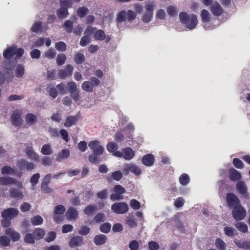

In [198]:
#Extract for prediction
tiles, tile_lvls, physSize = generate_deepzoom_tiles(oslide,250, 100)
tile_pull = tiles.get_tile(tile_lvls.index(20), (73, 8))
tile_pull = tile_pull.resize(size=(250, 250),resample=PIL.Image.LANCZOS)
tile_starts, tile_ends, save_coords, tile_coords = extract_tile_start_end_coords(tiles, tile_lvls.index(20), 73, 8)
tile_pull

In [ ]:
print('starting inference')
tile_count = 0
all_tile_count = 0
# pull tiles from levels specified by self.mag_extract
for lvl in mag_extract:
    if lvl in tile_lvls:
        # pull tile info for level
        x_tiles, y_tiles = tiles.level_tiles[tile_lvls.index(lvl)]
    
        tile_df_list = []
        for y in range(0, y_tiles):
            
            if y % 10 == 0:
                print(y)
                
            for x in range(0, x_tiles):
                cur_outname = "x" + str(x) + "_y" + str(y)

                # grab tile coordinates
                tile_starts, tile_ends, save_coords = extract_tile_start_end_coords(tiles, tile_lvls.index(20), x, y)
                
                
                # check for tissue membership
                tile_tiss = check_tissue(tile_starts=tile_coords[0], tile_ends=tile_ends,roi=tissue)
                if tile_tiss > 0.9:
                    tile_pull = tiles.get_tile(tile_lvls.index(lvl), (x, y))
                    tile_copy = tiles.get_tile(tile_lvls.index(lvl), (x, y))
                    ws = whitespace_check(im=tile_pull)
                    if ws < 0.9:
                        all_tile_count += 1
                        tile_pull = tile_pull.resize(size=(save_image_size, save_image_size),resample=PIL.Image.LANCZOS)

                        #segmentation
                        tile_pull = np.array(tile_pull)
                        
                        #Get tile position in x_count and x_map
                        map_xstart = int(np.floor(tile_coords[0][1] / lvl_resize))
                        map_xend = int(np.floor(tile_ends[1] / lvl_resize))
                        map_ystart = int(np.floor(tile_coords[0][0] / lvl_resize))
                        map_yend = int(np.floor(tile_ends[0] / lvl_resize))
                        
                        with learn.no_bar():
                            inp, pred_class, pred_idx, outputs = learn.predict(tile_pull[:, :, 0:3], with_input=True)
                        outputs_np = outputs.numpy()
                        output = PIL.Image.fromarray(outputs_np[1])
                        #resize for low-res
                        output = output.resize(size=(map_xend - map_xstart, map_yend - map_ystart),resample=PIL.Image.LANCZOS)
                        output_np = np.array(output)
                        
                        
                        #Add the following because it will give error for images that hard to detect the egdes example: OPX006,007,010...
                        try: 
                            x_count[map_xstart:map_xend,map_ystart:map_yend] += 1
                            x_map[map_xstart:map_xend,map_ystart:map_yend] += output_np[1]
                        except:
                            pass

                        #Save tiles if pred > 0.8
                        cur_xmap = x_map[map_xstart:map_xend,map_ystart:map_yend]
                        cur_x_count = x_count[map_xstart:map_xend,map_ystart:map_yend]
                        cur_x_count = np.where(cur_x_count < 1, 1, cur_x_count)
                        cur_xmap = cur_xmap / cur_x_count
                        
                        #Convert to image
                        tile_pull_RGB = tile_copy.convert('RGB')
                        tile_pull_RGB_np = np.array(tile_pull_RGB.resize((save_image_size, save_image_size), resample=PIL.Image.LANCZOS))

                        if np.any(cur_xmap > 0.8):
                            #print(x,y)
                            tile_count += 1
                            selected = 1
                            plt.imsave(save_location6 + cur_outname + "_GT08.png",tile_pull_RGB_np,dpi = 100)
                        else:
                            selected = 0
                            #plt.imsave(save_location6 + cur_outname + ".png",img_test,dpi = 100)

                        tile_df_list.append(pd.DataFrame({'SAMPLE_ID' : cur_id, 
                                                          'TILE_COOR' : cur_outname,
                                                          'SELECTED' : selected,
                                                          'Model_Selected': site}, index = [0]))
                            
    else:
        print("WARNING: YOU ENTERED AN INCORRECT MAGNIFICATION LEVEL")

In [ ]:
tile_df = pd.concat(tile_df_list)
tile_df.reset_index(drop = True, inplace = True)
tile_df.to_csv(save_location5 + cur_id + "tile_info.csv")

In [ ]:
print('post-processing')
x_count = np.where(x_count < 1, 1, x_count)
x_map = x_map / x_count
slideimg = PIL.Image.fromarray(np.uint8(x_map * 255))
slideimg = slideimg.convert('L')

In [ ]:
cmap = plt.get_cmap('jet')
rgba_img = cmap(x_map)
rgb_img = np.delete(rgba_img, 3, 2)
colimg = PIL.Image.fromarray(np.uint8(rgb_img * 255))
colimg.save(os.path.join(save_location5, save_name + '_cancer_prob.jpeg'))

In [ ]:
binary_preds = cancer_mask2(slideimg,he_mask, 0.8) 
polygons = tile_ROIS(mask_arr=binary_preds, lvl_resize=lvl_resize)
slide_ROIS(polygons=polygons, mpp=float(oslide.properties[openslide.PROPERTY_NAME_MPP_X]),
                savename=os.path.join(save_location5,save_name+'_cancer.json'), labels='AI_tumor', ref=[0,0], roi_color=-16711936)
slide_ROIS(polygons=tissue, mpp=float(oslide.properties[openslide.PROPERTY_NAME_MPP_X]),
                savename=os.path.join(save_location5,save_name+'_tissue.json'), labels='tissue', ref=[0,0], roi_color=-16770432)

In [ ]:
binary_preds.shape

In [ ]:
save_location5